# COVID-19 Pancreatic cells analysis

i dati sono stati scaricati dal sito: [single cell portal](https://singlecell.broadinstitute.org/single_cell/study/SCP883/hca-lungmap-covid-19-pancreas), le analisi sono state esguite utilizzando il modulo [scanpy](https://scanpy.readthedocs.io/en/stable/) in python

DATI:
I dati sono riferiti alle isole di langerhans provenienti da pazienti affetti da coronavirus, sani o con diabete di tipo 2 

OBIETTIVO:
L'analisi si pone l'obiettivo di suddividere le cellule in cluster e di estrarre per ogni cluster un "marker gene" di riferimento

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat

# creazione oggetto AnnData

In [2]:
dati=sc.read("pancreas.expression.txt")
#dati

#NB:righe e colonne sono invertiti, è necessario trasporre la matrice 

In [3]:
adata = dati.transpose()
adata

AnnData object with n_obs × n_vars = 2552 × 27

nel dataset sono presenti 2552 cellule e 27 geni, quali sono i geni contenuti?

In [4]:
adata.var_names_make_unique() 
sorted(adata.var_names.tolist())

['ACE2',
 'C1R',
 'C2',
 'C3',
 'C5',
 'CFI',
 'CTSB',
 'CTSC',
 'CTSE',
 'CTSL',
 'CTSS',
 'FURIN',
 'IL6',
 'IL6R',
 'IL6ST',
 'MAG',
 'MBP',
 'MOG',
 'MYRF',
 'PCSK1',
 'PCSK2',
 'PCSK4',
 'PCSK5',
 'PCSK6',
 'PCSK7',
 'PLP1',
 'TMPRSS2']

In [5]:
#check: controlliamo la matrice relativa alle espressioni geniche 
adata.X

array([[  0.,   0.,   0., ...,   0.,   1.,   0.],
       [  0.,   0.,   0., ...,   0.,   5.,   1.],
       [  0.,   0.,   0., ...,  10.,   4.,   0.],
       ...,
       [  0.,  22.,   8., ..., 132., 212.,   0.],
       [  0.,   0.,  44., ...,  61., 170.,   0.],
       [  0.,   0.,  19., ...,  19., 107.,   0.]], dtype=float32)

# import metadati

In [6]:
meta=pd.read_csv("pancreas.meta.txt",sep="\t",header=0)
meta=meta[1:]

In [7]:
meta

NAME original_cell_subset           CellType Patient_ID  \
1               AZ_A12                 Beta   Endocrine (Beta)          0   
2                AZ_A2               Acinar             Acinar          0   
3                AZ_A3                Gamma  Endocrine (Gamma)          0   
4                AZ_A4                Alpha  Endocrine (Alpha)          0   
5                AZ_A5                 Beta   Endocrine (Beta)          0   
...                ...                  ...                ...        ...   
2548  HP1526901T2D_P24                Alpha  Endocrine (Alpha)          9   
2549   HP1526901T2D_P3                Gamma  Endocrine (Gamma)          9   
2550   HP1526901T2D_P5                Alpha  Endocrine (Alpha)          9   
2551   HP1526901T2D_P7                Alpha  Endocrine (Alpha)          9   
2552   HP1526901T2D_P9                Alpha  Endocrine (Alpha)          9   

      filename                         dataset   nUMIs     Sample_ID Gender  \
1     pancreas  Pancreas_Healthy_Sandberg_2016    2707            AZ    NaN   
2     pancreas  Pancreas_Healthy_Sandberg_2016    6237            AZ    NaN   
3     pancreas  Pancreas_Healthy_Sandberg_2016   34338            AZ    NaN   
4     pancreas  Pancreas_Healthy_Sandberg_2016  398066            AZ    NaN   
5     pancreas  Pancreas_Healthy_Sandberg_2016  227594            AZ    NaN   
...        ...                             ...     ...           ...    ...   
2548  pancreas  Pancreas_Healthy_Sandberg_2016  329744  HP1526901T2D    NaN   
2549  pancreas  Pancreas_Healthy_Sandberg_2016  320371  HP1526901T2D    NaN   
2550  pancreas  Pancreas_Healthy_Sandberg_2016  277988  HP1526901T2D    NaN   
2551  pancreas  Pancreas_Healthy_Sandberg_2016  199488  HP1526901T2D    NaN   
2552  pancreas  Pancreas_Healthy_Sandberg_2016  136562  HP1526901T2D    NaN   

      Age          barcodes Count  
1     NaN            AZ_A12     1  
2     NaN             AZ_A2     1  
3     NaN             AZ_A3     1  
4     NaN             AZ_A4     1  
5     NaN             AZ_A5     1  
...   ...               ...   ...  
2548  NaN  HP1526901T2D_P24     1  
2549  NaN   HP1526901T2D_P3     1  
2550  NaN   HP1526901T2D_P5     1  
2551  NaN   HP1526901T2D_P7     1  
2552  NaN   HP1526901T2D_P9     1  

[2552 rows x 12 columns]

quanti pazienti sono presi in considerazione nel dataset?

In [8]:
patient_id_list=meta["Patient_ID"].unique()
patient_id_list

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

nello studio sono presenti 10 pazienti,  a ciascuno di essi è associato un campione cellulare unico

In [9]:
meta["Sample_ID"].unique().tolist()

['AZ',
 'HP1502401',
 'HP1504101T2D',
 'HP1504901',
 'HP1506401',
 'HP1507101',
 'HP1508501T2D',
 'HP1509101',
 'HP1525301T2D',
 'HP1526901T2D']

a quali possibili tipologie di cellule possono essere associate le osservazioni? quale è la loro distribuzione?

**NB:** tali informazioni sono state ottenute dai ricercatori che hanno per primi eseguito l'analisi 

In [10]:
celltype_list=meta["CellType"].unique()
celltype_list.tolist()

['Endocrine (Beta)',
 'Acinar',
 'Endocrine (Gamma)',
 'Endocrine (Alpha)',
 'Stromal (Fibroblast)',
 'Epithelial (Ductal)',
 'Endocrine (Delta)',
 'Stromal (Endothelial)',
 'Immune (Myeloid)']

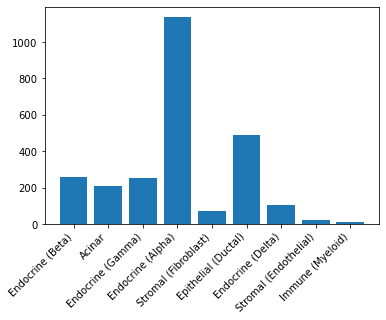

In [11]:
#calcoliamo il conteggio di ciascun tipo di cellula
valori=meta.groupby("CellType",sort=False).count()["Count"]

#grafico
plt.bar(celltype_list,valori)
plt.xticks(rotation=45,ha="right")
plt.show()

##### aggiungiamo alcune informazioni nei dati grezzi

In [12]:
adata.obs["CellType"]=meta["CellType"].tolist()

In [13]:
adata.obs["Patient_ID"]=meta["Patient_ID"].tolist()

# ANALISI INTRODUTTIVA

dato un singolo gene, quale è il peso che esso possiede all'interno di ciascuna cellula?

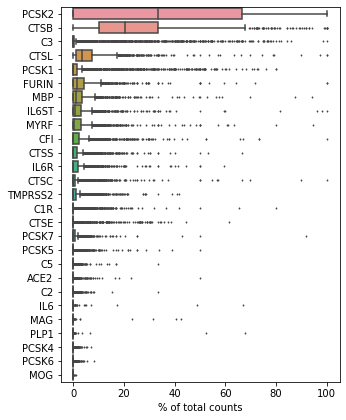

In [14]:
sc.pl.highest_expr_genes(adata,n_top=27)

i due geni che in media sono presenti in maniera preponderante fra tutte le cellule, sono: 

**PCSK2:** gene codificante per una proteina (Neuroendocrine convertase 2) responsabile per il rilascio di glucagone nelle cellule pancreatiche di tipo A

**CTSB:** gene codificante per una proteina (Cathepsin B) appartenente alle proteasi, tipiche dell'apparato digerente sono responsabili della scissione di altre proteine in amminoacidi, se sovraespressa può rappresentare un indicatore di tumore o infiammazzione cellulare 


**NB:** i geni che codificano per proteine legate all'ingresso di Sars-Cov-2 sono: CTSB , ACE2 , TMPRSS2

# 1. FILTERING

decidiamo di mantenere tutti i geni all'interno del dataset ma eliminamo tutte le cellule che possiedono nessun gene (23 cellule eliminate)

In [15]:
start=adata.n_obs

In [16]:
#eseguo il filtering
sc.pp.filter_cells(adata,min_genes=1)

#calcolo la differenza
end=adata.n_obs
start-end 

23

# 2. QUALITY CONTROL

calcoliamo alcune misure esplorative relative ai dati in analisi e ne analizziamo i risultati

In [17]:
sc.pp.calculate_qc_metrics(adata,percent_top=False,inplace=True)

In [18]:
#adata

... storing 'CellType' as categorical
... storing 'Patient_ID' as categorical


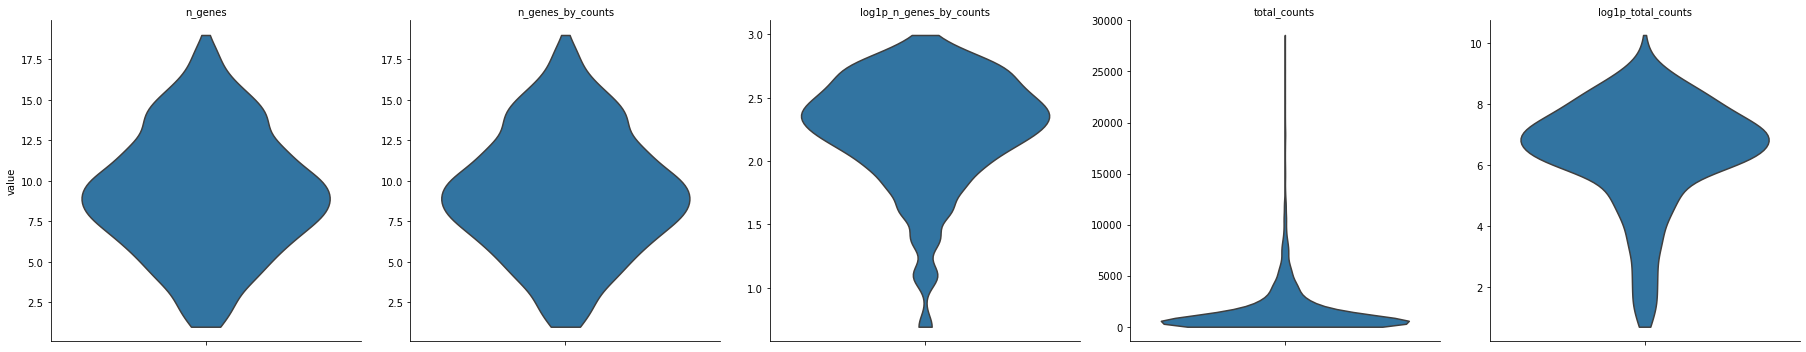

In [19]:
var_names=['n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts']
sc.pl.violin(adata, var_names, stripplot=False, multi_panel=True)

In [20]:
print(stat.mean(adata.obs["n_genes"]))
print(stat.mean(adata.obs["total_counts"]))

9.270067220245156
1614.6334519572954


il numero di geni presenti in ogni cellula risulta in media pari a 9 mentre l'espressione genica media risulta pari a 1615

ci concentriamo a questo punto solo sul numero di geni e sull'espressione genica: come si distribuiscono queste variabili entro paziente?

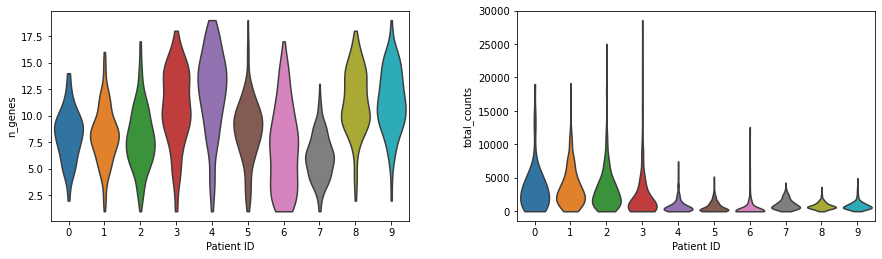

In [21]:
var_names=['n_genes', 'total_counts']
sc.pl.violin(adata, var_names ,groupby="Patient_ID",stripplot=False,multi_panel=True)

osservando i risultati decidiamo di eliminare il paziente numero sei dall'analisi in quanto presenta contemporaneamente un numero di geni in ciascuna cellula molto eterogeneo e un'espressione genica media molto bassa, riteniamo quindi tale paziente poco informativo

In [22]:
filtro= adata.obs["Patient_ID"] != "6"
adata=adata[filtro]

# 3. NORMALIZZAZIONE E TRASFORMAZIONE 

apportiamo alcune modifiche conclusive prima di procedere con la cluster analysis: 

1. eseguiamo la normalizzazione delle espressioni geniche (normalizzazione basata sull'espressione mediana)
2. eseguiamo la trasformazione dei dati tramite la funzione y=log(x+1) 
3. standardizziamo i dati 

In [23]:
adata=adata.copy()
sc.pp.normalize_total(adata)

In [24]:
sc.pp.log1p(adata)

In [25]:
sc.pp.scale(adata)

# 5. UMAP

utilizziamo la tecnica umap (Uniform manifold approximation and projection) per la riduzione di dimensionalità della matrice delle espressioni geniche:

In [26]:
%%time  
#NB: processore 1.80 GHz (4 core) e 8 GB di RAM

#sc.pp.neighbors(adata)        #NB: default n_neighbors=15  
sc.pp.neighbors(adata,n_neighbors=8)

Wall time: 30.2 s


In [27]:
sc.tl.umap(adata)

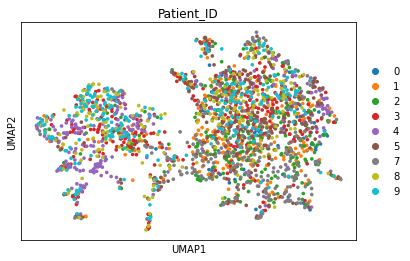

In [28]:
sc.pl.umap(adata,color="Patient_ID") 

analizziamo i risultati entro gene

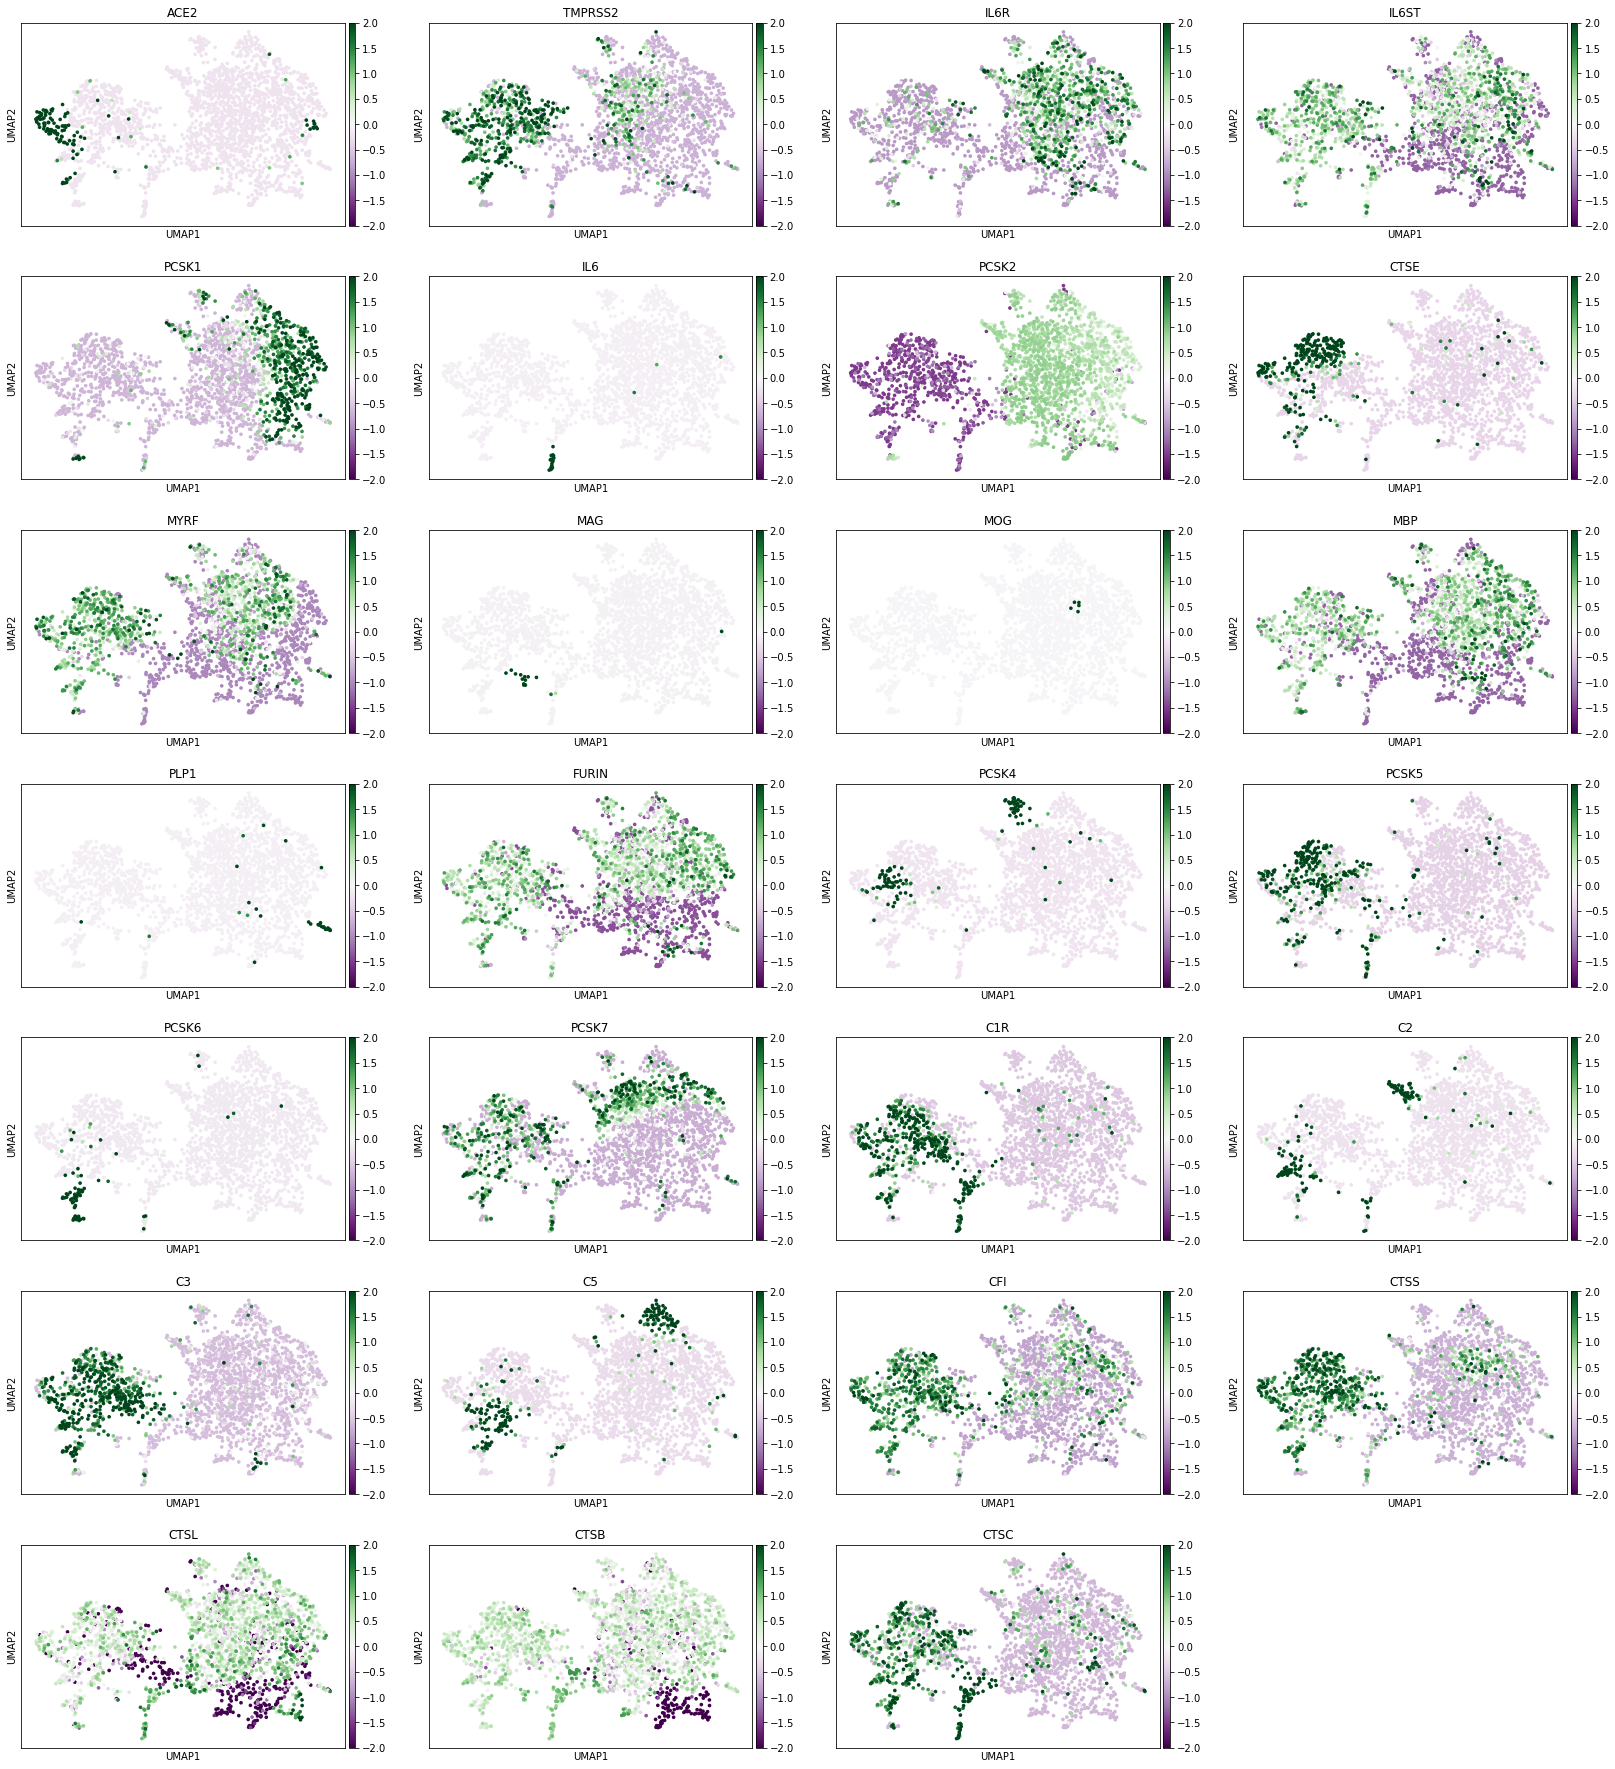

In [29]:
axes=sc.pl.umap(adata,color=adata.var.index,vmin=-2,vmax=2,color_map="PRGn")

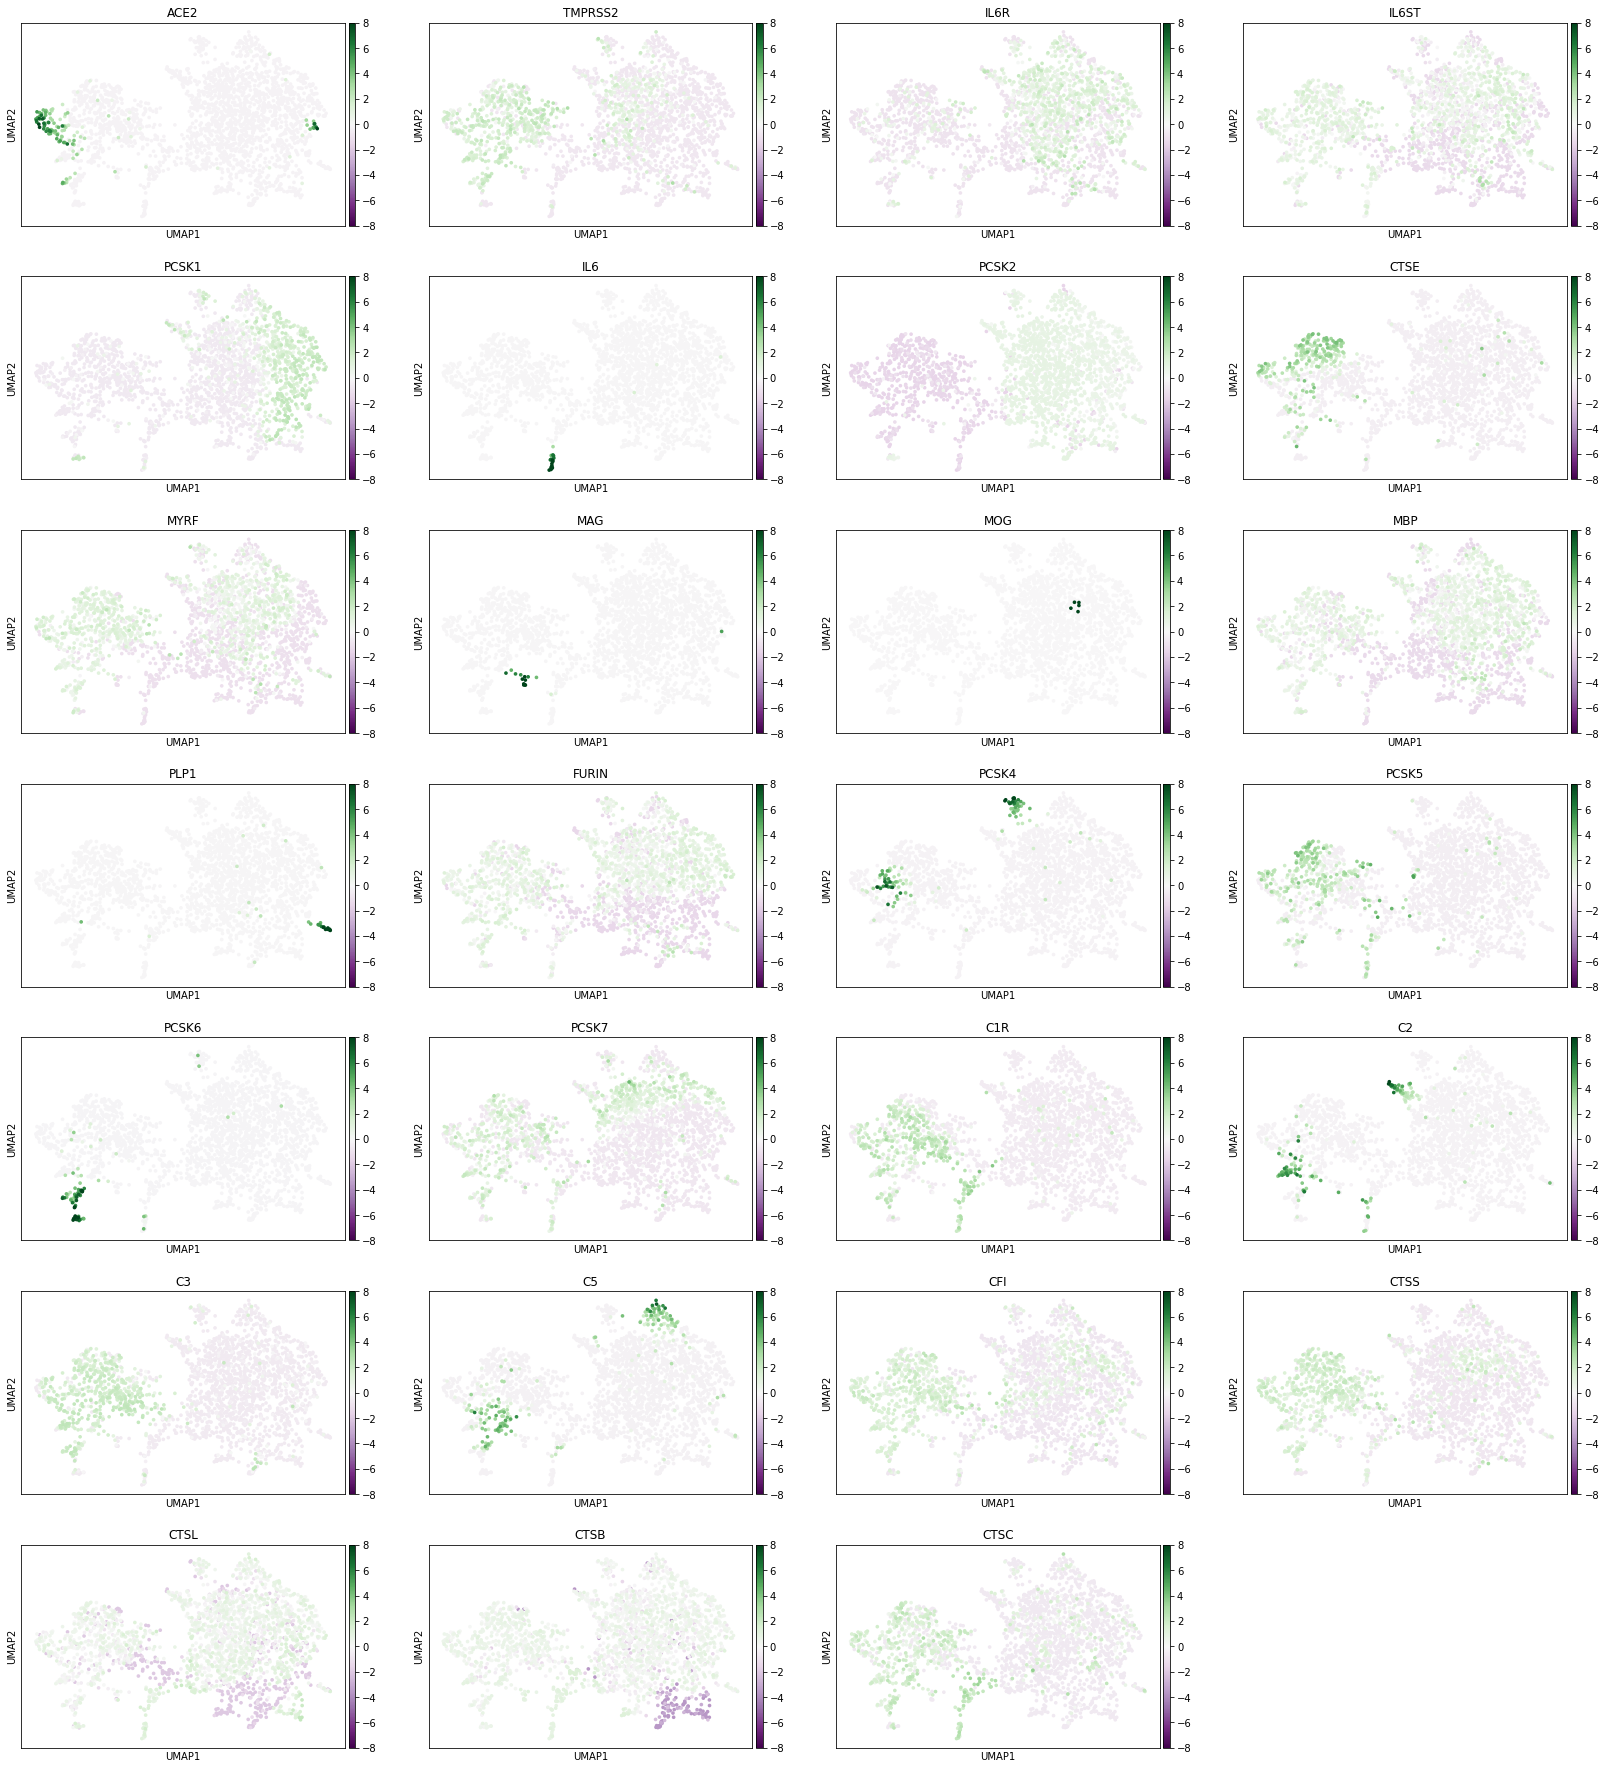

In [30]:
axes=sc.pl.umap(adata,color=adata.var.index,vmin=-8,vmax=8,color_map="PRGn")

**COMMENTO:**<br> i geni che sembrano essere maggiormente significativi sono:

1. [ACE2](https://www.uniprot.org/uniprot/Q9BYF1) : codifica per una proteina che si lega con le proteine spike di Sars-CoV-2
2. [IL6](https://www.uniprot.org/uniprot/P05231) : codificante per la famiglia delle interleuchine, indica la presenza di un infiammazzione 
3. [MAG](https://www.uniprot.org/uniprot/P20916-1) , [MOG](https://www.uniprot.org/uniprot/Q16653-1) e [PLP1](https://www.uniprot.org/uniprot/P60201-1) codificano per proteine legate alla guaina mielinica
4. [PCSK4](https://www.uniprot.org/uniprot/Q6UW60-1) e [PCSK6](https://www.uniprot.org/uniprot/P29122-1) relativi alla convertasi di proteine (tipiche di processi infiammatori)
5. [C2](https://www.uniprot.org/uniprot/P06681-1) e [C5](https://www.uniprot.org/uniprot/P01031) relativi al "complement system" uno dei componenti del sistema immunitario   

# 6. CLUSTERING

utilizziamo il metodo di leiden (estensione del metodo di louvain) per stabilire l'assegnazione dei cluster considerando i network cellula-gene presenti nel dataset

In [31]:
sc.tl.leiden(adata)

In [32]:
sc.set_figure_params(figsize=(8,8))

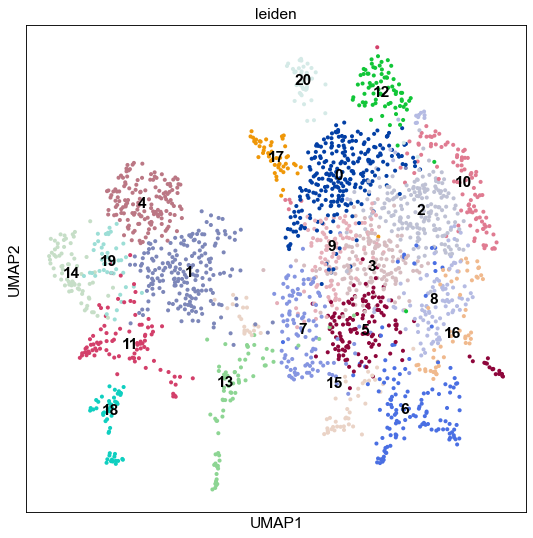

In [33]:
sc.pl.umap(adata, color='leiden',legend_loc="on data")

otteniamo 20 cluster 

### estrazione marker genes

utilizziamo un test per stabilire una classifica dei geni all'interno dei cluster, nello specifico usiamo il test t tramite il quale confrontiamo l'espressione media tra tutti i geni ed osserviamo quale risulta statisticamente differente

C:\Users\ferro\anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


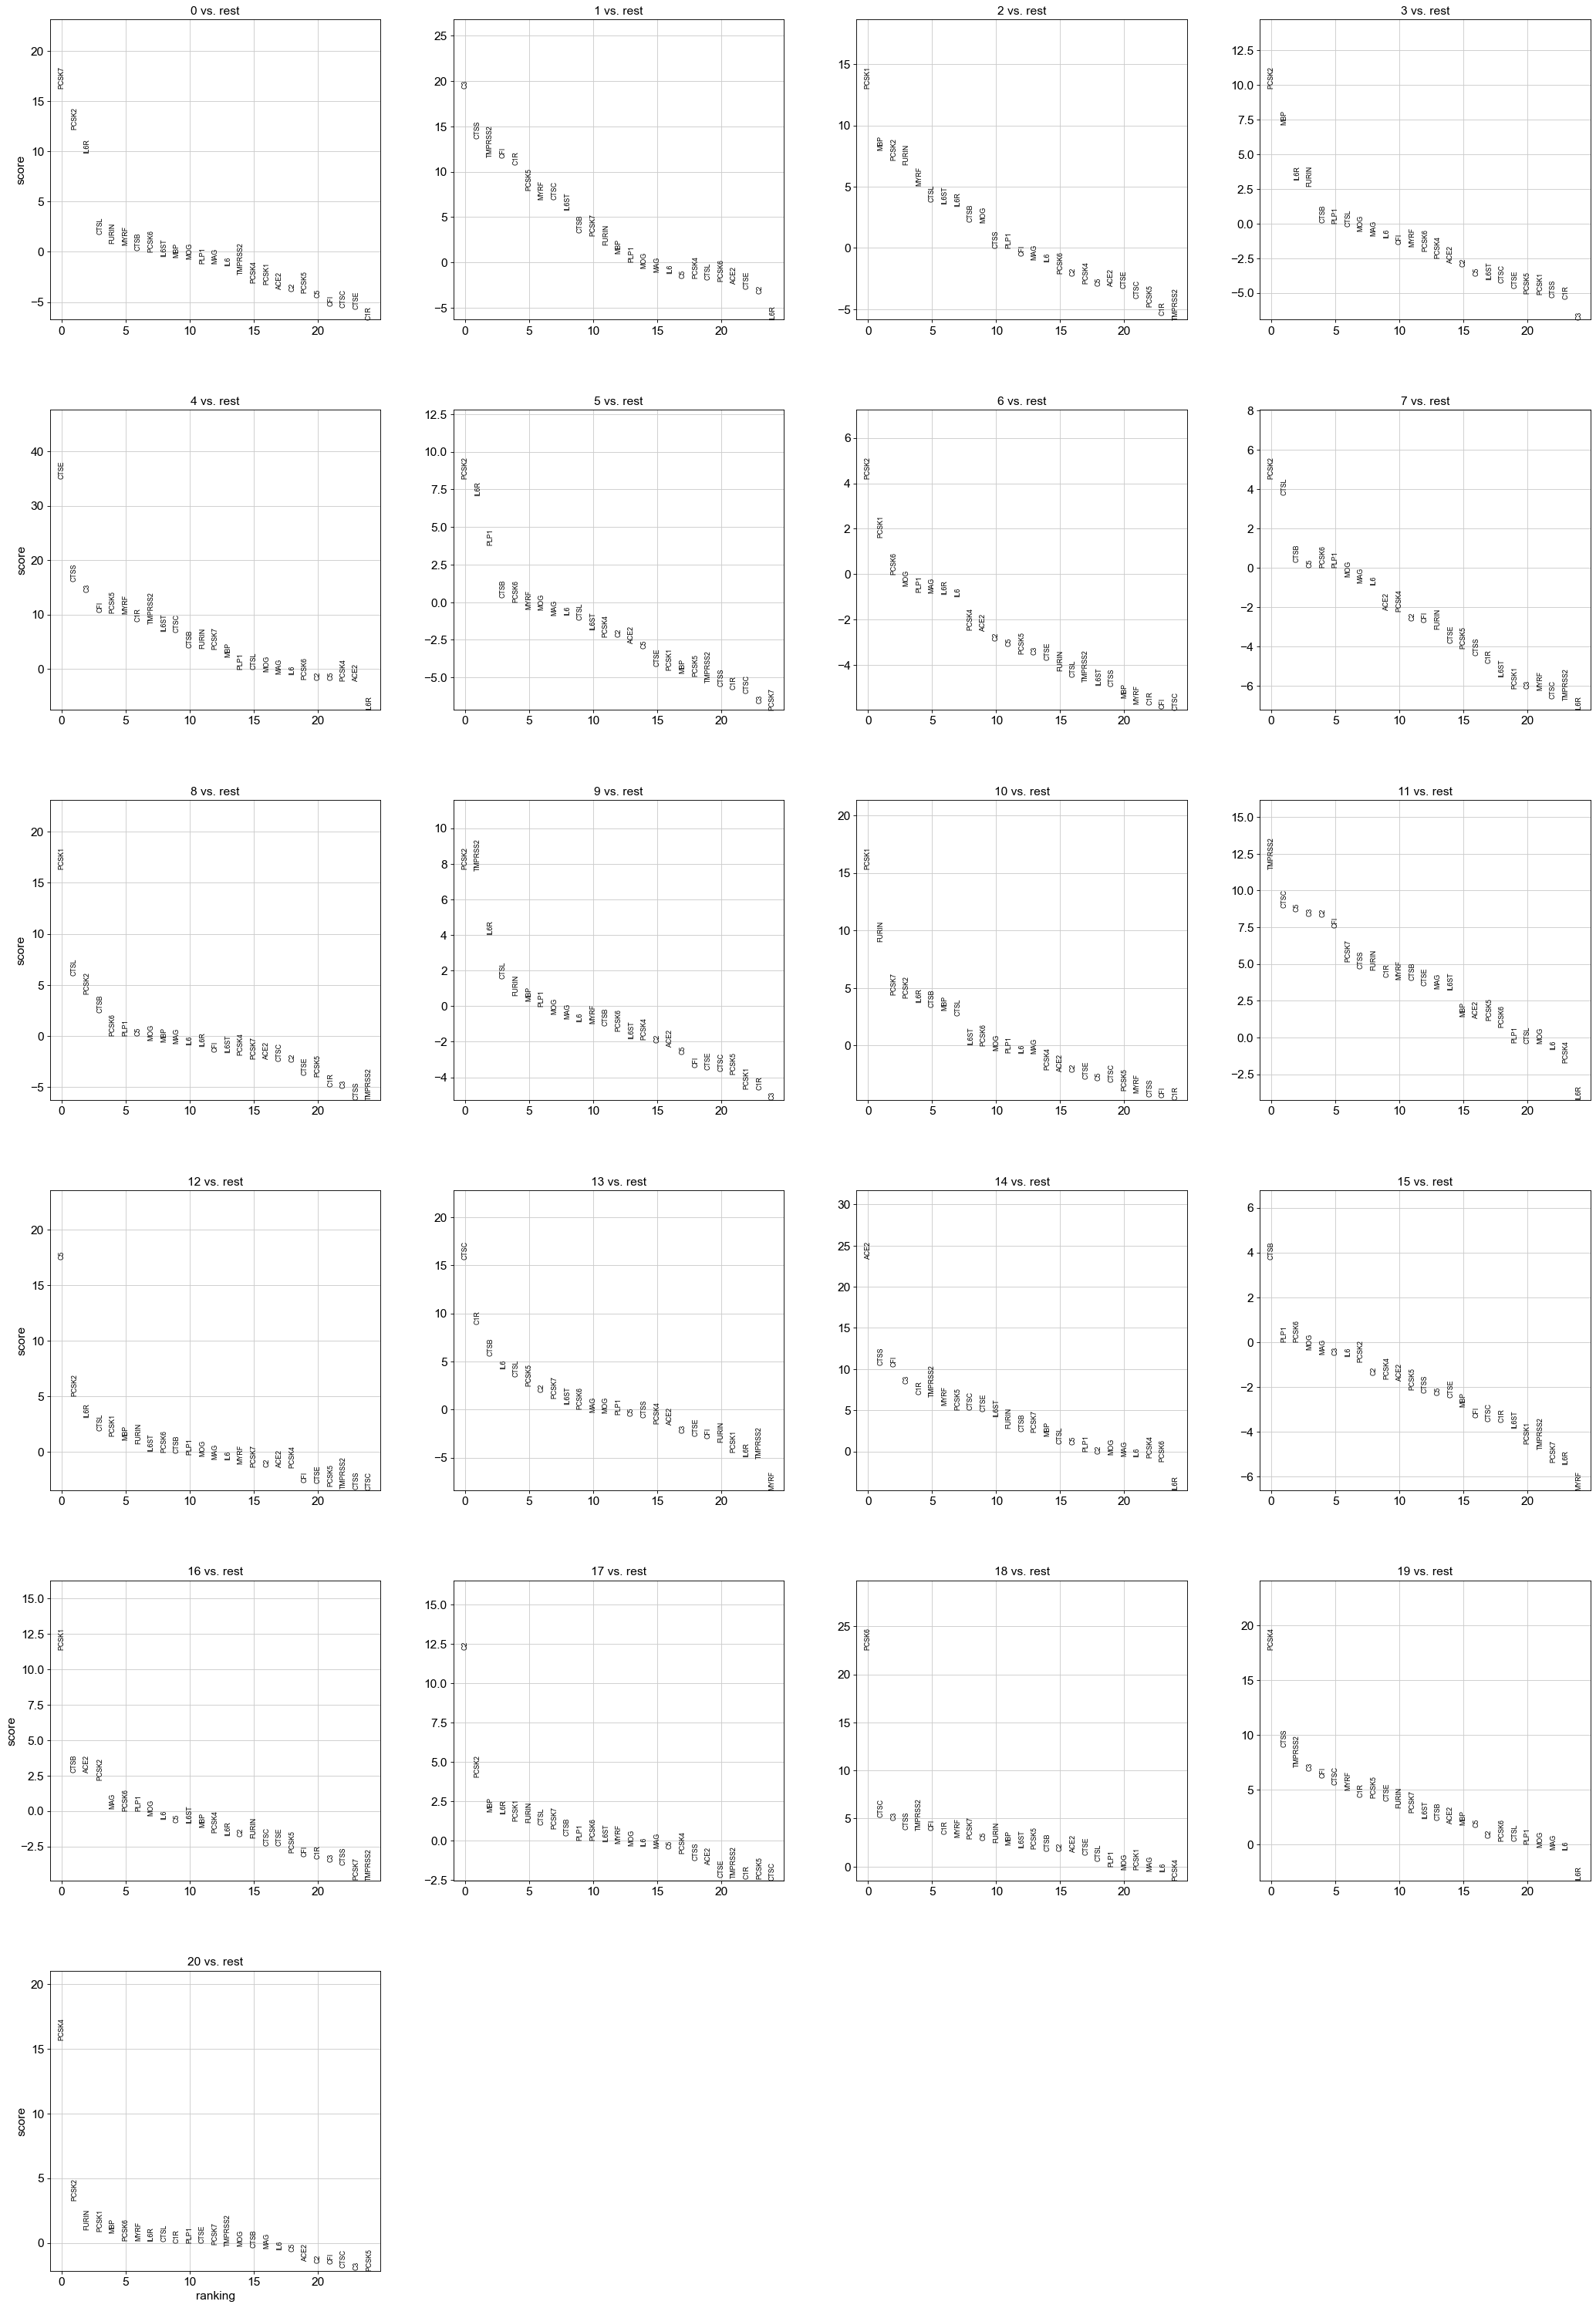

In [34]:
#sc.settings.verbosity = 3    
sc.tl.rank_genes_groups(adata, 'leiden',method='t-test_overestim_var')   #NB: metodo del t-test

#grafico:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

selezioniamo i geni predominanti per ogni cluster e li definiamo "marker genes", infine rappresentiamo i cluster in relazione al gene marker di riferimento

In [35]:
filtro = pd.DataFrame(adata.uns['rank_genes_groups']['names']).index==0
marker_genes= pd.DataFrame(adata.uns['rank_genes_groups']['names']).loc[filtro].transpose()[0].tolist()

#marker_genes

In [36]:
# dizionario che assegna ad ogni cluster il suo gene più frequente
cluster2annotation = {}

for clust, el in enumerate(marker_genes ,start=0):
    cluster2annotation[f"{clust}"]=el
    
#cluster2annotation    

In [37]:
adata.obs['gene_predominante'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

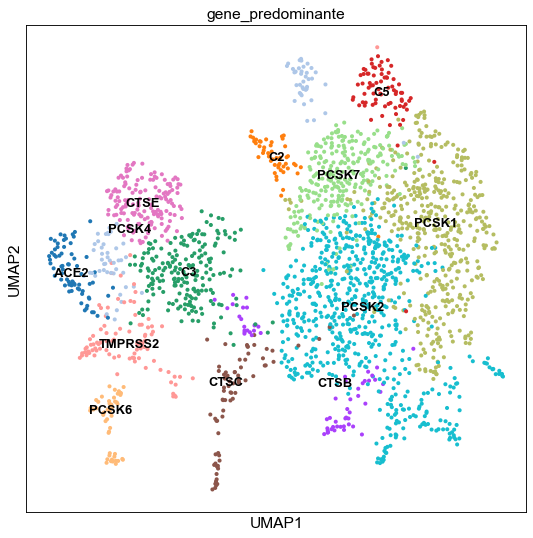

In [38]:
sc.pl.umap(adata,color="gene_predominante",legend_loc="on data",legend_fontsize="small")

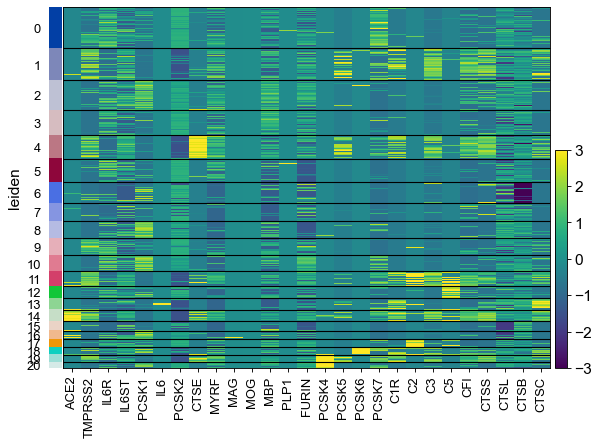

In [39]:
sc.pl.heatmap(adata, adata.var_names, groupby="leiden", vmin=-3, vmax=3)